# Aufgabe für die Projektgruppe 3

Bearbeiten Sie die folgende Aufgabe:

Ihr Auftraggeber ist eine Familie, welche eine Beratung von Ihnen benötigt. Sie besitzt ein kleines altes Windrad, welches nur für den Eigenverbrauch genutzt wird sowie eine PV Anlage. Die Familie möchte von Ihnen wissen, ob Sie Kosten durch die Investition in verschiedene Komponenten ihres Energiesystems einsparen kann. 

Nehmen Sie dabei die folgenden Angaben an:
* Nennleistung der Windernergieanlage: 5 kW (Keine EEG- Vergütung)
* Nennleistung der PV-Anlage 9 kWp (70% Kappungsgrenze berücksichtigen)
* Die Anschlussleistung an das elektrische Netz beträgt 15 kW
* Die Heizleistung des Erdgaskessel liegt bei 20 kW, der Wirkungsgrad ist 99%
* Erdgaspreis: 7 cent/kWh
* Strompreis: 30 cent/kWh
* EEG-Vergütung PV Anlage: 12,30 cent/kWh

Prüfen und kombinieren Sie mindestens drei der unten aufgeführten Optionen und bewerten Sie diese nach ihrer wirtschaftlicher Vorteilhaftigkeit. Unter den gewählten Optionen sollte sich mindestens eine der beiden Optionen BHKW oder Wärmepumpe befinden:
- Implementierung eines Heizstabes mit annuitätische Kosten von 50€ (Elektrische Leistung 5 kW, Wirkungsgrad 98%) 
- Installation eines BHKWs mit annuitätische Kosten von 1.200€ (Elektrische Leistung 1kW, elektrischer Wirkungsgrad 16%, Thermischer Wirkungsgrad 80%, nehmen Sie eine feste Stromkennzahl von 0,2 an, ein Beispiel für die Implementierung eines BHKWs in PyPSA finden Sie hier: https://pypsa.org/examples/chp-fixed-heat-power-ratio.html. Eine KWK-Vergütung müssen Sie nicht implementieren, da hier die pauschalierte Zuschlagzahlung gewählt wird.)
- Beschaffung einer elektrischen Batterie mit annuitätische Kosten von 900€ (8kWh Kapazität, 2,4 kW Speicher und Ladeleistung, einem Gesamtwirkungsgrad von 85%, keine Selbstentladungsverluste) 
- Erweiterung des Heizungssystems um einen thermischen Speicher mit annuitätische Kosten von 100€ (7kWh Kapazität und eine Ein und Ausspeicherleistung von 12 kW, keine Selbstentladungsverluste)
- Implementierung einer selbst gewählten Wärmepumpe. Hier müssen Sie nach geeigneten Daten zu Leistungen, Kosten und Performance recherchieren. Sie dürfen dabei die Jahresarbeitszahl als konstanten COP annehmen. Gehen Sie weiter davon aus, dass der Annuitätenfaktor für eine solche Investition bei 0,117 liegt.

1) Formulieren Sie die Optimierungsaufgabe
2) Skizzieren Sie das heutige System und bestimmen Sie die Kosten.
3) Skizzieren Sie mögliche Erweiterungen und bestimmen Sie die Kosten.
4) Interpretieren Sie die ihre Ergebnisse und ziehen Sie Schlussfolgerungen.
5) Bestimmen Sie die Grenzen Ihrer Modellierung und begründen Sie, ob die Ergebnisse trotz der Beschränkungen valide sind.

Der Import der Lastzeitreihen und der Einspeisezeitreihen ist unten schon vorbereitet. Diese repräsentieren das Jahr 2018 in stündlicher Auflösung. Nutzen Sie das in der Übung besprochene JupyterNotebook und schauen Sie sich die Funktionen und den Code dort an, um Ihr Energiesystem aufzubauen, es zu simulieren und auszuwerten.  

# Import <a class="anchor" id="chapter1"></a>

## Import der benötigten Python Module <a class="anchor" id="section_1_1"></a>

In [113]:
import pypsa
import pandas as pd
import math
import numpy as np

## Import der Daten <a class="anchor" id="section_1_2"></a>

Die Werte der Zeitreihen sind in einem Unterordner "data" als csv-Datein abgelegt. Sie bilden das Jahr 2019 ab und werden mithilfe des Python Moduls pandas eingelesen und als Variablen angelegt. Dabei werden Parameter wie der Separator (hier ";") und die Indexspalte sowie die Funktion, aus der Indexspalte Zeit und Datenformate auszulesen gesetzt.

In [114]:
pv_infeed = pd.read_csv('./data/pv_infeed.csv', sep = ',', skiprows =3, index_col='time', parse_dates=True)
wind_infeed = pd.read_csv('./data/wind_infeed.csv', sep = ',', skiprows =3, index_col='time', parse_dates=True)

In [115]:
electrical_load = pd.read_csv('./data/SumProfiles_3600s.Electricity.csv', sep = ';', index_col='time', parse_dates=True)
thermal_load = pd.read_csv('./data/SumProfiles_3600s.Gas.csv', sep = ';', index_col='time', parse_dates=True)


Die eingelesenen Zeitreihen sind so noch nicht vollständig nutzbar. Um die Einspeisung der Wind und PV-Anlage zu normieren wird eine neue Spalte mit dem normierten Leistungsoutput sowie neue Spalten mit der Leistung der Last in den jeweiligen Variablen angelegt.

In [116]:
#Die gemessene PV-Einspeiseganglinie ist von einer Anlage mit einer Leistung von 9 kWp, die der Windenergieanlage mit 5 kW.
pv_infeed['p_max_pu'] = pv_infeed.electricity/9 
wind_infeed['p_max_pu'] = wind_infeed.electricity/5 

Um einen kurzen Einblick in die Daten zu erhalten, schauen wir uns alle vier Tabellen an:

array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>],
      dtype=object)

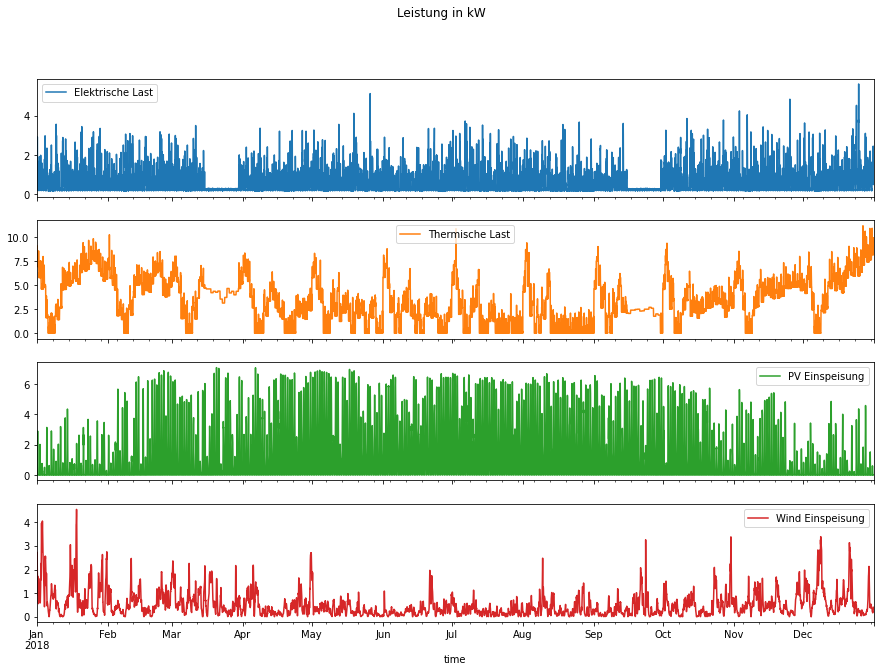

In [117]:
df_figure = pd.concat([electrical_load.sum_kwh, thermal_load.sum_kwh, pv_infeed.electricity,wind_infeed.electricity], axis = 1)
df_figure.columns = ['Elektrische Last', 'Thermische Last', 'PV Einspeisung', 'Wind Einspeisung']
df_figure.loc['01-01-18 00:00:00':'12-31-18 23:00:00'].plot(subplots = True, figsize=(15,10), title= 'Leistung in kW')

In [118]:
# Ab hier können Sie selbst Code schreiben und das Energiesystem simulieren.

# Definition der Variablen und Objekte <a class="anchor" id="chapter2"></a>

## Definition von Anlagenparametern <a class="anchor" id="section_2_1"></a>

### Komponenten des Haushalts <a class="anchor" id="section_2_1_1"></a>

In [119]:
# PV-Anlage
pv = {"electrical_power": 9.0} #Leistung der PVA wird auf 9 kW festgelegt

# Wind-Anlage
wind = {"electrical_power": 5.0} #Leistung der WEA wird auf 5 kW festgelegt

#Heizkessel
heating_boiler = {"thermal_power": 20.0, #Leistung des Erdgaskessel wird auf 20 kW festgelegt
                   "efficiency":0.99,# Effizienz des Erdgaskessel wird auf 99% festgelegt
                   "gas_costs": 7} #Erdgaspreis wird auf 7 cent/kWh festgelegt                   

### Netzanschluss <a class="anchor" id="section_2_1_2"></a>

Der Netzanschluss wird für den Haushalt mit 15 kW angenommen. Hier ist auch eine Kappungsgrenze bei 70% der Nennleistung der PV-Anlage implementiert.

In [120]:
# Leistungsbezug aus dem Netz
grid_import = {"electrical_power" : 15, #maximale Bezugsleistung aus dem Netz
                "electricity_price": 30.0} #Preis für den Netzbezug in cent/kWh

#PV Leistungsabgabe in das Netz
grid_export_pv = {"electrical_power_pv" : 0.7 * pv["electrical_power"], #Repräsentiert die 70% Kappungsgrenze bei kleinen PV-Anlagen
                "electricity_revenue": 12.3} #EEG-Erlöse in cent/kWh für Einspeisung

#Wind Leistungsabgabe in das Netz
grid_export_wind = {"electrical_power_wind" : wind["electrical_power"], #
                "electricity_revenue": 0} #EEG-Erlöse in cent/kWh für Einspeisung


## Verwendung von PyPSA um das Energiemodell aufzubauen <a class="anchor" id="section_2_2"></a>

### Definition des Netzwerks  <a class="anchor" id="section_2_2_1"></a>

In [121]:
#Netzwerk definieren
network = pypsa.Network() # Die Variable für das Netzwerk wird eingefüht und als PyPSA Objekt, definiert
network.set_snapshots(pv_infeed.index) #Erstellen der Zeitabschnitten aus den PV-Daten
network.snapshot_weightings = pd.Series(data = 1/6, index = network.snapshots) #Jeder Zeitpunkt repräsentiert 10 Minuten also 1/6 Stunde.

### Knoten definieren <a class="anchor" id="section_2_2_2"></a>

In [122]:
#Stromknoten erstellen
network.add("Bus", #der Knoten für die Elektische Seite wird erstellt
            name = "electricity") #der Knoten für die Elektische Seite wird benannt

#Wärmeknoten erstellen
network.add("Bus", 
            name = "thermal")

#Erzeugungsknoten erstellen
#network.add("Bus", #der Knoten für die Elektische Erzugungs Seite wird erstellt
#            name = "electricity_production") #der Knoten für die elektische Erzeugung wird benannt

### Verbindung zwischen Erzeugung und Stromknoten

In [123]:
#network.add("Link", 
#            name="Erzeugung", 
#            bus0="electricity_production", 
#            bus1="electricity", 
#           )

### Lasten definieren <a class="anchor" id="section_2_2_3"></a>

In [124]:
# Elektrische Last
network.add("Load", #Die elektrische Last wird erstellt
            name ="electricity_load", #Name wird gesetzt
            bus = "electricity", #angeschlossen am Knoten für Elektrik
            p_set = electrical_load.sum_kwh) #auslesung der Leustung aus der Datei.Spalte Umrechnung in kW nicht notwendig, da Zeitintervall in der Quelle 1h

# Thermische last
network.add("Load", 
            name ="thermal_load", 
            bus = "thermal", 
            p_set = thermal_load.sum_kwh)


### Erzeugungseinheiten definieren <a class="anchor" id="section_2_2_4"></a>

In [125]:
#PV-Anlage
network.add("Generator", 
            name = "pv",
            bus = "electricity", 
            p_nom = pv["electrical_power"], 
            p_max_pu = pv_infeed.p_max_pu, 
            marginal_cost = 0)


#Wind-Anlage
network.add("Generator",
            name = "wind",
            bus = "electricity", 
            p_nom = wind["electrical_power"], #Leistung wird von oben aus der Variable abgerufen (hätte man auch hie eintippen können)
            p_max_pu = wind_infeed.p_max_pu, #Maximalleitung je Zeitpunkt wird aus der Datei gelesen 
            marginal_cost = 0)#keine Erzeugungkosten



#Heizkessel
network.add("Generator", 
            name = "boiler", 
            bus = "thermal", 
            p_nom = heating_boiler["thermal_power"], #werte werden von oben ausgelsen
            efficiency=heating_boiler["efficiency"], 
            marginal_cost = heating_boiler["gas_costs"]/heating_boiler["efficiency"]) #kosten werden mit den Angaben oben errechneet

### Netzanschluss definieren <a class="anchor" id="section_2_2_6"></a>

In [126]:
#Netzbezug
network.add("Generator", 
            name = "grid_import",
            bus = "electricity", 
            p_nom = grid_import["electrical_power"], 
            marginal_cost = grid_import["electricity_price"])

#Netzeinspeisung pv
network.add("Generator", 
            name = "grid_export_pv",
            bus = "electricity", 
            p_nom = grid_export_pv["electrical_power_pv"], 
            marginal_cost = -grid_export_pv["electricity_revenue"], #Die Kosten müssen hier negativ sein, um Erlöse darzustellen
            sign = -1) #Das Vorzeichen -1 sorgt hier dafür, dass der Generator Leistung aufnimmt und nicht abgibt.

#Netzeinspeisung wind
network.add("Generator", 
            name = "grid_export_wind",
            bus = "electricity", 
            p_nom = grid_export_wind["electrical_power_wind"], 
            marginal_cost = -grid_export_wind["electricity_revenue"], #Die Kosten müssen hier negativ sein, um Erlöse darzustellen
            sign = -1) #Das Vorzeichen -1 sorgt hier dafür, dass der Generator Leistung aufnimmt und nicht abgibt.

# Simulation <a class="anchor" id="chapter3"></a>

## Simulation der Basiskonfiguration <a class="anchor" id="section_3_1"></a>

In [127]:
# Simulation der Basiskonfiguration für den kompletten Zeitraum:
network.lopf(solver_name = "glpk", pyomo = False) #Der Parameter pyomo = False hilft uns bei diesem Netzwerk RAM und Rechenzeit zu sparen.

INFO:pypsa.linopf:Prepare linear problem
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:85: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  ext_i = ext_i | n.generators.query('committable').index
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:185: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  if not (ext_i & com_i).empty:
INFO:pypsa.linopf:Total preparation time: 0.82s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 1.49e+04


('ok', 'optimal')

In [128]:
#Auswertung der Kosten und Anteile
def cost_share_evaluation(network):
    '''
    This function evaluate the solved PyPSA network to get the costs, revenues and the share of the selfconsumption.
    
    Parameters
    ----------
    network:            PyPSA Network
                        The solved PyPSA network with all corresponding devices
    Returns
    -------
    results :           dict
                        The dictionary with all the results.
    '''
    
    production_pv =(network.generators_t.p['pv'] * network.snapshot_weightings).sum()
    production_wind =(network.generators_t.p['wind'] * network.snapshot_weightings).sum()
    
    grid_import = (network.generators_t.p['grid_import'] * network.snapshot_weightings).sum() #was wurde aus dem Netz bezogen (Jeweilige realleitung "p" des generators "grid_import" * jeweilige zeit [kw*h] und davon die Summe)  
    
    grid_export_pv = (network.generators_t.p['grid_export_pv'] * network.snapshot_weightings).sum()
    grid_export_wind = (network.generators_t.p['grid_export_wind'] * network.snapshot_weightings).sum() #was wurde eingespeißt 
    grid_export_all = grid_export_pv+grid_export_wind
    
    self_consumed_pv = (network.generators_t.p['pv'] * network.snapshot_weightings).sum() - grid_export_all - grid_export_wind
    self_consumed_wind = (network.generators_t.p['wind'] * network.snapshot_weightings).sum() - grid_export_all - grid_export_pv
    self_consumed_all = self_consumed_pv + self_consumed_wind
    
    self_consumption_ratio_pv = self_consumed_pv/(network.generators_t.p['pv'] * network.snapshot_weightings).sum()
    self_consumption_ratio_wind = self_consumed_wind/(network.generators_t.p['pv'] * network.snapshot_weightings).sum()
    self_consumption_ratio_all = self_consumed_all/((network.generators_t.p['pv'] * network.snapshot_weightings).sum() + (network.generators_t.p['wind'] * network.snapshot_weightings).sum())
    
    electricity_cost = grid_import * network.generators.marginal_cost['grid_import']
    electricty_revenues = grid_export_pv * network.generators.marginal_cost['grid_export_pv']
    gas_costs = (network.generators_t.p['boiler']*network.snapshot_weightings).sum() * network.generators.marginal_cost['boiler']
    
    curtailment = ((network.generators_t.p_max_pu['pv']*network.generators.p_nom['pv'] - network.generators_t.p['pv'])*network.snapshot_weightings).sum()

    results = {"Erzeugung_PV":production_pv,
              "Erzeugung_wind":production_wind,
              "Eigenverbrauchsanteil_pv": self_consumption_ratio_pv,
              "Eigenverbrauchsanteil_wind": self_consumption_ratio_wind,
              "Eigenverbrauchsanteil_all": self_consumption_ratio_all,
              "Stromkosten": electricity_cost,
              "Gaskosten": gas_costs,
              "Stromerlöse": -electricty_revenues,
              "Gesamtkosten": electricity_cost + gas_costs + electricty_revenues,
              "Nicht nutzbare Energie": curtailment}
    results_energy = {'Abregelung': curtailment,
                      'Netzeinspeisung_pv': grid_export_pv,
                      'Netzeinspeisung_wind': grid_export_wind,
                      'Netzeinspeisung_all': grid_export_all,
                      'Eigenverbrauch_pv': self_consumed_pv,
                      'Eigenverbrauch_wind': self_consumed_wind,
                      'Eigenverbrauch_all': self_consumed_all,
                      'Netzbezug': -grid_import}
                      
    return results, results_energy

In [129]:
results_base, results_energy_base  = cost_share_evaluation(network)

#Die Werte sollen auch als Text ausgegeben werden
print("Erzeugung_PV "+str(round(results_base["Erzeugung_PV"],2)))
print("Erzeugung_wind "+str(round(results_base["Erzeugung_wind"],2)))
print("Eigenverbrauchsanteil_pv "+str(round(results_base["Eigenverbrauchsanteil_pv"],2)))
print("Eigenverbrauchsanteil_wind "+str(round(results_base["Eigenverbrauchsanteil_wind"],2)))
print("Eigenverbrauchsanteil_all "+str(round(results_base["Eigenverbrauchsanteil_all"],2)))

Erzeugung_PV 1847.34
Erzeugung_wind 725.8
Eigenverbrauchsanteil_pv -0.08
Eigenverbrauchsanteil_wind -1.76
Eigenverbrauchsanteil_all -1.32


In [130]:
#results_base, results_energy_base  = cost_share_evaluation(network)

#Die Werte sollen auch als Text ausgegeben werden
#print("Der Eigenverbrauchsanteil am Stromverbrauch in der Basiskonfiguration beträgt "
#      + str(round(results_base["Eigenverbrauchsanteil_all"]*100,2))
#      +"%. Dabei entstehen Stromkosten von "
#      +str(round(results_base["Stromkosten"]/100,2))
#      +"€, Gaskosten von "
#      +str(round(results_base["Gaskosten"]/100,2))
#      +"€ und EEG-Erlöse von "
#      +str(round(results_base["Stromerlöse"]/100,2))
#      +", wobei " +str(round(results_base["Nicht nutzbare Energie"]/100,1))+ "kWh PV-Strom abgeregelt werden muss."
#      +" Die Gesamtkosten betragen "+ str(round(results_base["Gesamtkosten"]/100,2)) +"€."
#     )